# Filtracja bilateralna

## Konwolucja obrazu z filtrem o zadanych współczynnikach
![Konwolucja](https://aigeekprogrammer.com/wp-content/uploads/2019/12/CNN-konwolucja-9.png)  
Splot (konwolucję) obrazu wejściowego $I$ z filtrem $\psi$ dla ustalonego punktu obrazu $\mathbf{x}$ można przedstawić następująco:

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||)I(\mathbf{p})
\end{equation}

gdzie:
- $\hat{I}$ jest obrazem wynikowym (przefiltrowanym),
- $W_N = \sum_y \psi(y)$ jest parametrem normalizującym współczynniki filtra $\psi$,
- $||\cdot||$ jest odległością między punktami obrazu $\mathbf{x}$ i $\mathbf{p}$ według ustalonej metryki (np. norma $L_2$). Uwaga, proszę pamiętać, że zarówno $\mathbf{x}$, jak i $\mathbf{p}$ to współrzędne przestrzenne,
- $\eta(\mathbf{x})$ jest otoczeniem punktu $\mathbf{x}$.

Funkcja $\psi$ decyduje o charakterze filtracji. Dla filtru Gaussowskiego:

\begin{equation}
\psi(y) = G_{\delta_s}(y)
\end{equation}

gdzie: $G_{\delta_s}(y)$ jest funkcją Gaussa z parametrem skali $\delta_s$.

Opisaną powyżej filtrację realizowaliśmy w ramach ćwiczenia "Przetwarzanie wstępne. Filtracja kontekstowa."

## Filtracja bilateralna

Wadą klasycznego splotu jest brak adaptacji współczynników filtra do lokalnego otoczenia $\eta(\mathbf{x})$ filtrowanego punktu $\mathbf{x}$.
Oznacza to wykorzystanie tych samych współczynników filtra $\psi$ niezależnie od tego czy otoczenie jest względnie jednorodne lub zawiera krawędzie obiektów (w tym przypadku dochodzi do "rozmywania" krawędzi).
Filtracja bilateralna uwzględnia lokalne otoczenie filtrowanego punktu, w ten sposób, że parametry filtra zmieniają się w zależności od "wyglądu" otocznia.


Współczynniki filtra obliczane są na podstawie odległości filtrowanego punktu $\mathbf{x}$ od każdego punktu otoczenia $\mathbf{p}$ w dziedzinie przestrzennej obrazu (tak jak przy typowym filtrze np. Gaussa) oraz odległości punktów w przeciwdziedzinie obrazu (np. na podstawie różnicy w jasności pikseli dla obrazu w odcieniach szarości):

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||) \gamma(|I(\mathbf{p}) - I(\mathbf{x})|) I(\mathbf{p})
\end{equation}
gdzie:
- $W_N$ jest współczynnikiem normalizującym filtr,
- $\gamma$ jest funkcją odległości w przeciwdziedzinie obrazu, np. $\gamma(y)=\exp(-\frac{y^2}{2\delta_r^2})$
- parametr $\delta_r$ jest utożsamiany z poziomem szumu w obrazie i należy go dobrać w sposób empiryczny.

Proszę chwilę zastanowić się nad powyższym równaniem, w szczególności nad funkcją $\gamma$. Proszę wyznaczyć, jaka będzie wartość funkcji dla pikseli podobnych (różnica 0, 1, 2), a skrajnie różnych (255, 200).

##  Realizacja ćwiczenia

### Wczytanie danych

1. Wczytaj dane z pliku *MR_data.mat*. W tym celu wykorzystaj funkcję `loadmat` z pakietu scipy:
        from scipy.io import loadmat
        mat = loadmat('MR_data.mat')

2. Wczytany plik zawiera 5 obrazów: *I_noisefree*, *I_noisy1*, *I_noisy2*, *I_noisy3* oraz *I_noisy4*. Odczytać je można w następujący sposób:
        Input = mat['I_noisy1']

3.Wyświetl wybrany obraz z pliku *MR_data.mat*. Zagadka - co to za obrazowanie medyczne?

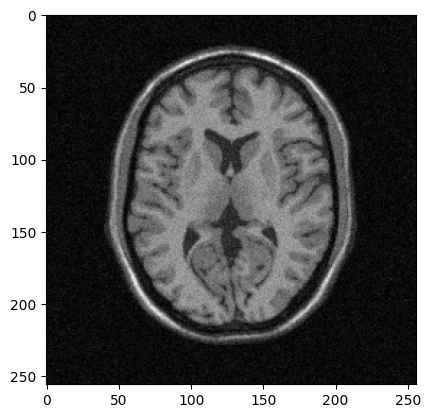

In [1]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import loadmat
import math

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/'

fileNames = ["MR_data.mat"]
for fileName in fileNames:
  if not os.path.exists(fileName):
      r = requests.get(url + fileName, allow_redirects=True)
      open(fileName, 'wb').write(r.content)

mr_data = loadmat('MR_data.mat')
img = mr_data['I_noisy1']
plt.imshow(img, cmap='gray')



### "Klasyczna" konwolucja

1. Zdefiniuj parametry filtra Gaussowskiego: rozmiar okna i wariancję $\delta_S$.
2. Oblicz współczynniki filtra na podstawie zdefiniowanych parametrów (najprościej w ramach podwójnej pętli for).
2. Sprawdź ich poprawność i zwizualizuj filtr (tak jak w ćwiczeniu pt. "Przetwarzanie wstępne. Filtracja kontekstowa.").
3. Wykonaj kopię obrazu wejściowego: `IConv = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentem tej funkcji są aktualnie przetwarzane okno i współczynniki filtra.
7. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
8. Wyświetl wynik filtracji.
9. Porównaj wynik z obrazem oryginalnym.

In [6]:
def gaussian(x, sigma):
    '''
    Returns the value of the Gaussian function. 
    It gets the value by plotting 3d Gaussian curve and taking the z value (height) at the given coordinates.
    '''
    return np.exp(-np.power(x, 2) / (2 * np.power(sigma, 2)))

def getKernelValues(window, sigma):
    half_kernel_size = window // 2
    kernel = np.zeros((window, window))

    for i in range(window):
        for j in range(window):
            dx = i - half_kernel_size
            dy = j - half_kernel_size
            dist = np.sqrt(dx * dx + dy * dy)
            kernel[i, j] = gaussian(dist, sigma)

    return kernel / np.sum(kernel)


def Convolution(img, window, sigma_s, sigma_r) -> None: #sigma odchylenie standardowe
    half_window = int(window / 2)
    kernel = getKernelValues(window, sigma_s)
    processed = np.zeros(img.shape)

    # New image size: height of pic - 2 * half_window, width of pic - 2 * half_window
    for i in range(half_window, img.shape[0] - half_window):
        for j in range(half_window, img.shape[1] - half_window):
            window = img[i - half_window:i + half_window + 1, j - half_window:j + half_window + 1]
            kernel_r = gaussian(window - img[i, j], sigma_r)
            kernel_w = kernel * kernel_r
            processed[i, j] = np.sum(kernel_w * window) / np.sum(kernel_w)

    plt.figure()
    plt.imshow(processed, cmap='gray')
    plt.show()

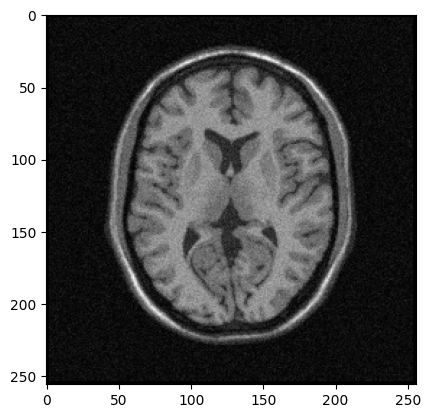

In [7]:
brain = img.copy()
Convolution(brain, 5, 1, 1)

### Filtracja bilateralna

1. Zdefiniuj dodatkowy parametr: wariancję $\delta_R$.
3. Wykonaj kopię obrazu wejściowego: `IBilateral = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentami funkcji są aktualnie przetwarzane okno, współczynniki filtra gausowskiego (takie same jak wcześniej) i wariancja $\delta_R$.
7. Oblicz odległość w przeciwdziedzinie (dla wartości pikseli).
8. Oblicz funkcję Gaussa dla obliczonych odległości z zadanym parametrem.
9. Wykonaj normalizację obliczonych współczynników.
10. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
11. Wyświetl wynik filtracji.
12. Porównaj wynik z obrazem oryginalnym.

In [2]:
def BilateralConvolution(image, window, sigma_r, sigma_s):
    def getBilateralKernelValues(window, sigma_r, sigma_s):
        half_kernel_size = window // 2
        kernel = np.zeros((window, window))
        # brightness kernel

        for i in range(window):
            for j in range(window):
                dx = i - half_kernel_size
                dy = j - half_kernel_size
                dist = np.sqrt(dx * dx + dy * dy)
                kernel[i, j] = gaussian(dist, sigma_r) * gaussian(window[i, j] - window[half_kernel_size, half_kernel_size], sigma_s)

        return kernel / np.sum(kernel)

    half_window = int(window / 2)

    new_image = np.zeros(image.shape)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            window = image[i - half_window:i + half_window + 1, j - half_window:j + half_window + 1]
            bilateral_kernel = getBilateralKernelValues(window, sigma_r, sigma_s)
            
            new_image[i, j] = np.sum(bilateral_kernel * window)

    return new_image

In [ ]:
sigma_s = 1
sigma_r = 1

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)